In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import data
import numpy as np
import requests

In [ ]:
#empty and irrelevant columns to remove from the dataset
columns = ["generation hydro pumped storage aggregated", "forecast wind offshore eday ahead", "generation fossil coal-derived gas", "generation wind offshore", "generation marine", "generation geothermal",
"generation fossil peat","generation fossil oil shale","forecast solar day ahead","forecast wind onshore day ahead"]

df = data.load_data(dataset = "../datasets/energy_updated.csv")
df = data.preprocessing(df,columns = columns)
df.describe()



In [ ]:
#Find missing timestamps
from datetime import timedelta,datetime
new_df = pd.DataFrame(
    pd.date_range(
        start=df.index.min(), 
        end=df.index.max(),
        freq='H'
    ).difference(df.index)
)
missing_columns = [col for col in df.columns if col!="time"]

# add null data
new_df[missing_columns] = np.nan

# fix column names
new_df.columns = ["time"] + missing_columns

print(new_df)


In [ ]:
#rename columns if needed

columns = []
for name in df.columns:

    if "generation" in name:
        renamed =  name.replace("generation","")
        df = df.rename(columns = {name: renamed})

df.columns

In [5]:

trainx,testx,trainy,testy, end_validation = data.split_data(df,"total load actual","2023-03-01 23:00:00",'2023-06-30 23:00:00')

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [9]:
# Resample target values to daily for easier visualisation or testing
dfdaily = df.resample("D").mean()
dailytrainx,dailytestx,dailytrainy,dailytesty, dailyend_validation = data.split_data(dfdaily,"total load actual","2023-03-01 23:00:00",'2023-06-30 23:00:00')

In [ ]:
dfdaily.index[:dailyend_validation]

In [ ]:
#daily average load plot
def daily_plot():
    plt.figure(figsize=(16, 6))
    plt.title("Daily Average Total")
    plt.tick_params(axis='x')
    plt.tick_params(axis='y')
    plt.xlabel("date")
    plt.ylabel("total load")
    plt.plot(dfdaily.loc[:dailyend_validation].index, dfdaily["total load actual"].loc[:dailyend_validation])
    plt.plot(dailytestx.index, dailytesty,color = "orange")
    plt.legend(['training set','test set'])


daily_plot()

In [ ]:
#create lag feature
dfcopy = pd.DataFrame()
#dfcopy["lag"] = df["total load actual"].shift(1)

for x in range(6):
    name = "lag"+str(x)
    dfcopy[name] = df["total load actual"].shift(x+1)
    
print(dfcopy.head)



In [ ]:
#relationship between target and lagged target, exploring serial dependance in the dataset


dfcopy = pd.concat([dfcopy,df["total load actual"]],axis = 1)
dfcopy = dfcopy.dropna()
print(dfcopy.columns)
print(dfcopy.corr())
print(dfcopy.head)

fig, axs = plt.subplots(6)
for x in range(6):
    seaborn.regplot(x=dfcopy["lag"+str(x)], y=dfcopy["total load actual"], data=dfcopy, ci=None, scatter_kws=dict(color='0.25'),ax=axs[x])


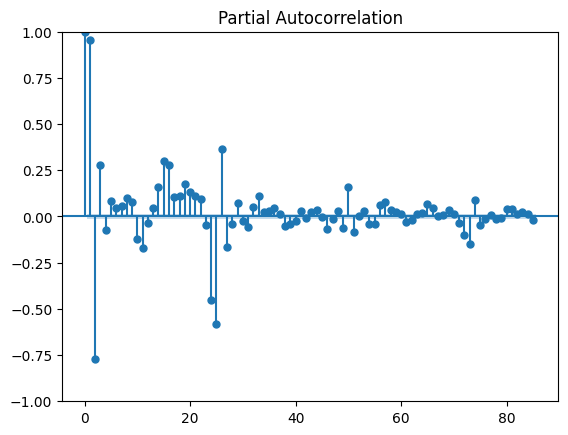

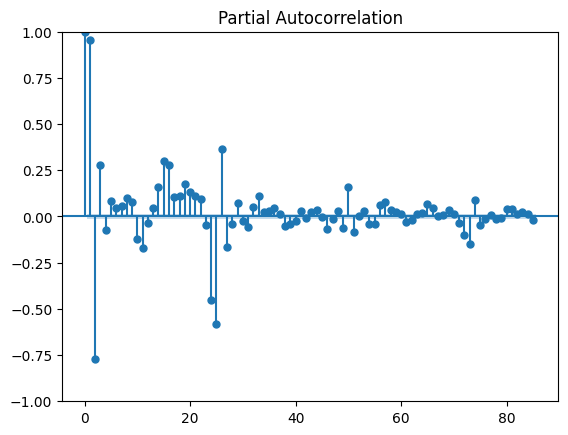

In [37]:
plot_pacf(dfcopy["total load actual"], lags=85)

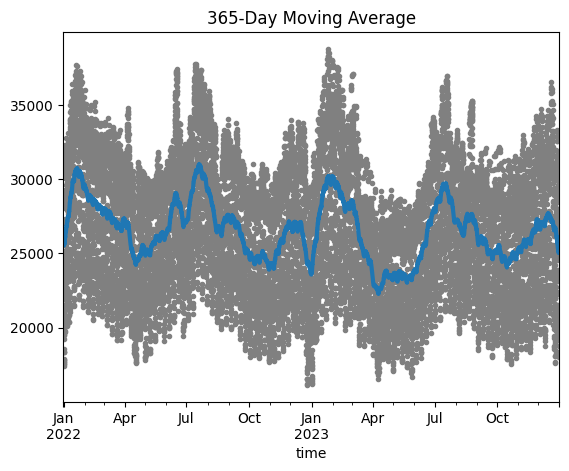

In [44]:
#trend shown using moving average plot

dftarget = df["total load actual"]
moving_average = dftarget.rolling(window = 365, center = True, min_periods=183).mean()
ax = dftarget.plot(style=".", color="grey")
moving_average.plot(ax=ax, linewidth=3, title="365-Day Moving Average", legend=False,)




dp = DeterministicProcess(
    index=trainx.index,  
    constant=True,       
    order=1,              
    drop=True,           
)
X = dp.in_sample()



In [25]:
model = LinearRegression(fit_intercept=False)
model.fit(X,trainy)
y_pred = pd.Series(model.predict(X), index = X.index)

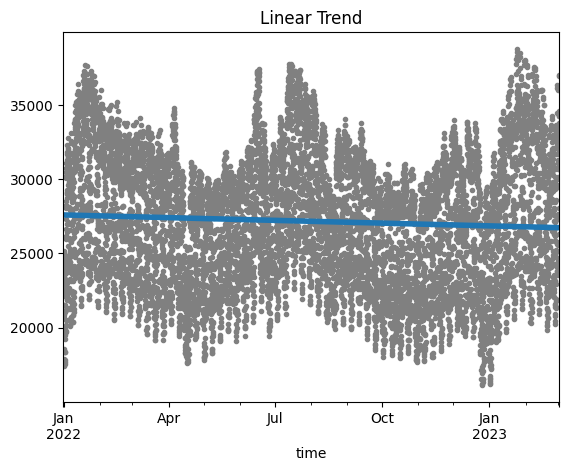

In [42]:
ax = trainy.plot(style=".", color="0.5", title="Linear Trend",xlabel = "total load")

_ = y_pred.plot(ax=ax, linewidth=4, label="Trend")

<AxesSubplot: >

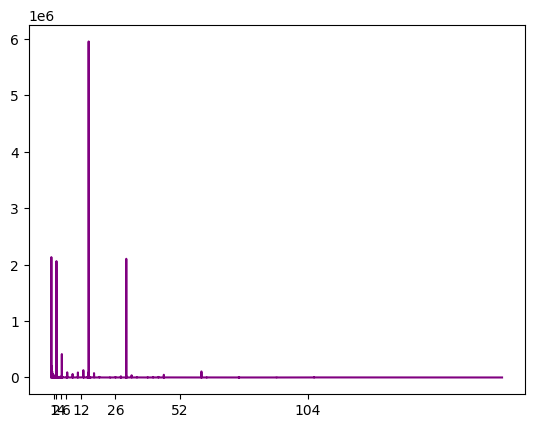

In [28]:
#seasonality
def feature_plot(data,feature,period):
    plt.figure(figsize=(8, 6))
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.plot(data[period], data[feature])

#feature_plot(df,"total load actual","year")

#periodogram
def plot_periodogram():
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        df["total load actual"],
        fs=fs,
        detrend="linear",
        window="boxcar",
        scaling='spectrum',
    )
    
    _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    #ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])

    return ax
 
plot_periodogram()    


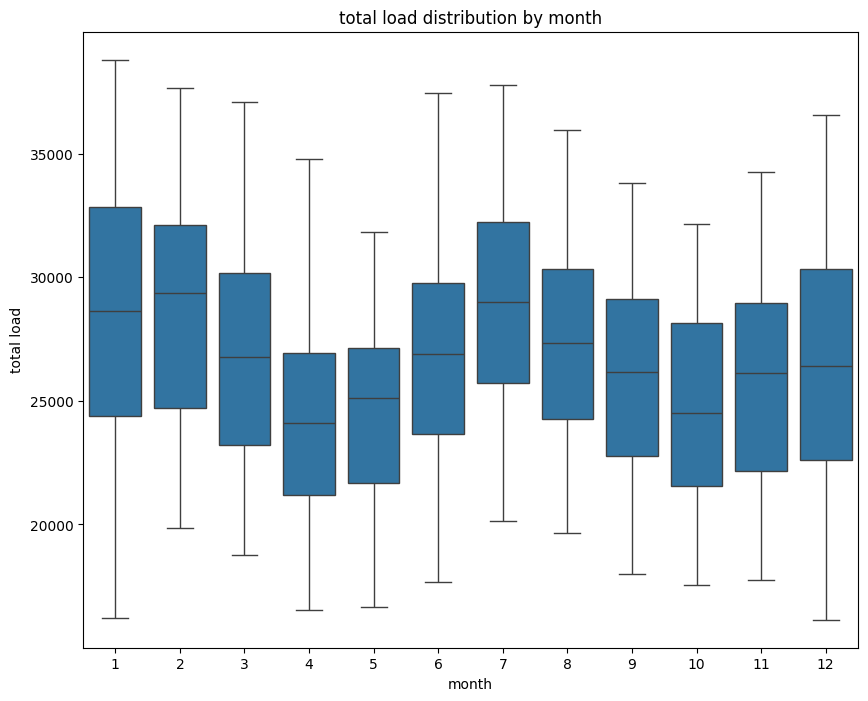

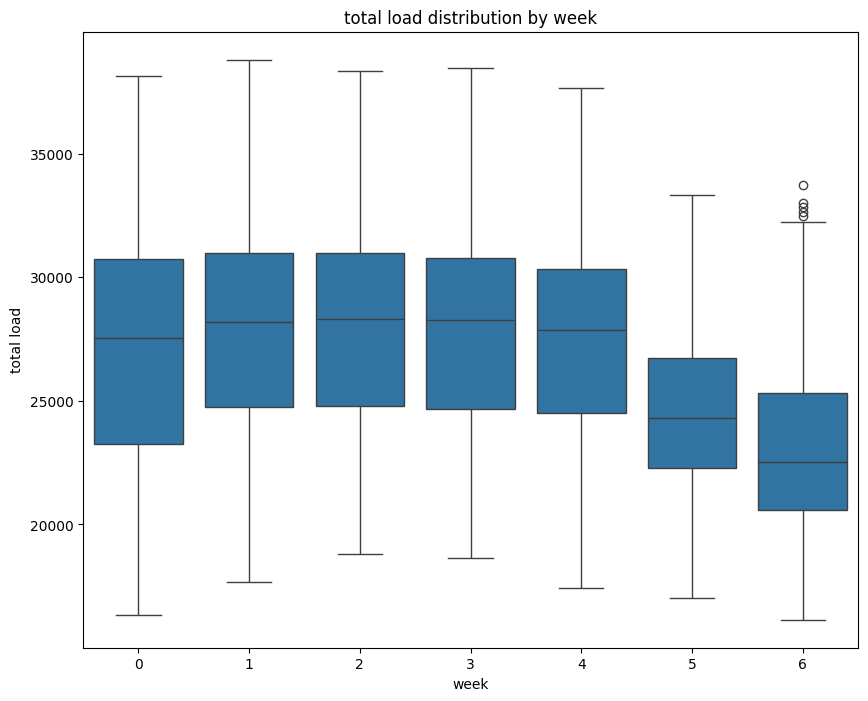

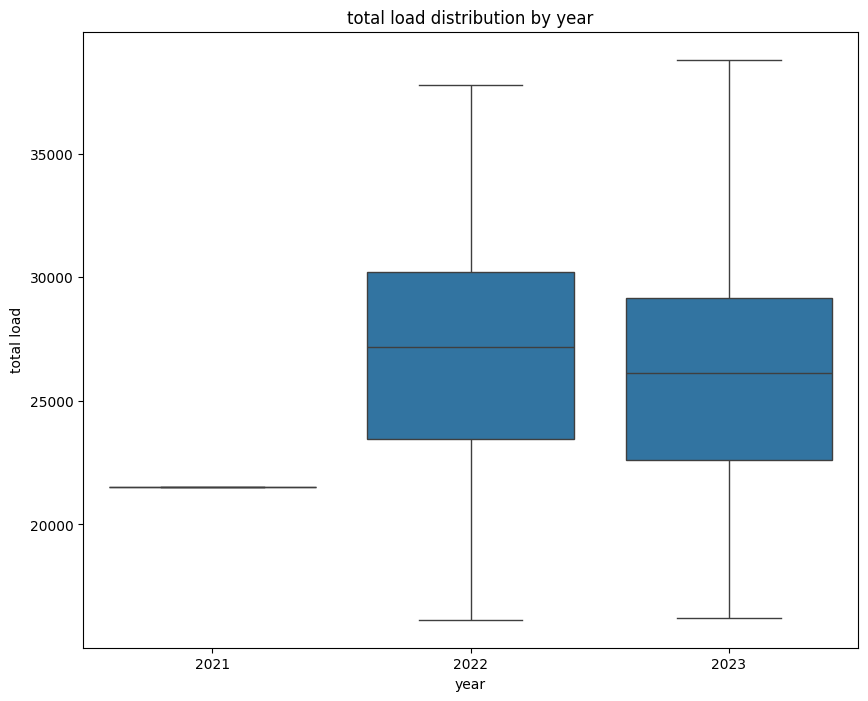

In [34]:

def boxplots(time_period):
    fig,axs = plt.subplots(figsize=(10,8))
    data = zip(df[time_period], df["total load actual"])
    for x in range(3):
        seaborn.boxplot(data = df,x = time_period,y = "total load actual", ax = axs)

        axs.set_ylabel("total load")
        axs.set_title(f"total load distribution by {time_period}")

        plt.show()

boxplots("month")
boxplots("week")
boxplots("year")




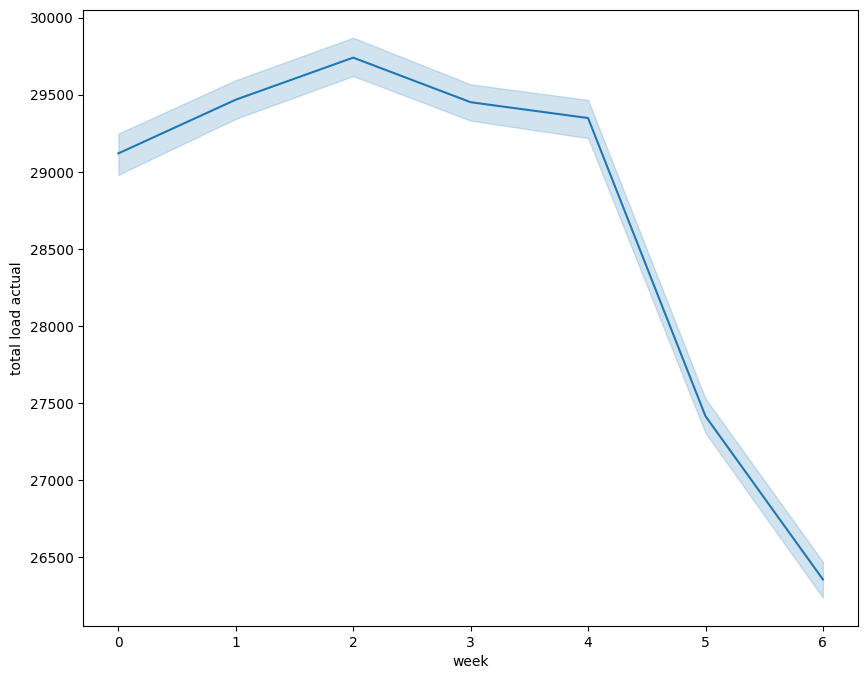

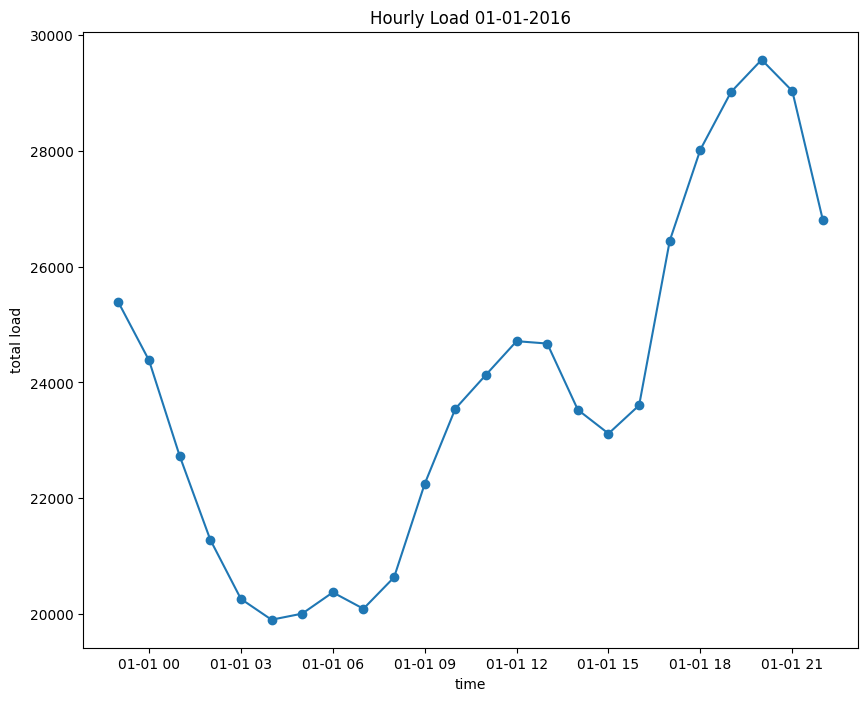

In [31]:
def feature_plot(data,feature):
    plt.figure(figsize=(8, 6))
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.plot(data.index, data[feature])

def multi_plot(features):
    fig,axs = plt.subplots(len(features),figsize=(16,48))
    for x in range(len(features)):
        axs[x].plot(df.index, df[features[x]])
        axs[x].set_title(features[x],color = "white")
        axs[x].tick_params(axis='x', colors='white')
        axs[x].tick_params(axis='y', colors='white')
        
    fig.tight_layout()
def plot_season(time_period):
    fig,axs = plt.subplots(figsize=(10,8))
    data = zip(df[time_period], df["total load actual"])
    seaborn.lineplot(data = df,x = time_period,y = "total load actual", ax = axs)
    
#feature_plot(dfdaily,"total load actual")
#multi_plot(["generation biomass","generation fossil brown coal/lignite","generation fossil gas"])
plot_season("week")
fig,axs = plt.subplots(figsize=(10,8))
plt.plot(df.index[0:24],df["total load actual"].iloc[0:24],"o-")
plt.title("Hourly Load 01-01-2016")
plt.xlabel('time')
plt.ylabel('total load')
plt.show()

In [ ]:
#plot all features
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(2, 1, 1)
for column in df:
    ax.plot(df.index, df[column])
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_yscale("log")
ax.legend()